Preparation:
- git load ipyleaflet, geopandas, leafmap
- install only once

In [3]:
%%bash

#Matplotlib,Pillow,Pandas,Mamba,Geopandas,Geemap,Leafmap
#sudo pip install protobuf-compiler
pip -q install shapely
pip -q install pygeos
pip -q install rtree
pip -q install geopy
pip -q install gjf
pip -q install matplotlib
pip -q install pillow
pip -q install xyzservices
pip -q install pandas
pip -q install mamba
pip -q install jupyter_contrib_nbextensions
pip -q install geopandas
pip -q install keplergl
pip -q install python-Levenshtein

#jupyter nbextension install --py --symlink --sys-prefix ipyleaflet
#jupyter nbextension enable --py --sys-prefix ipyleaflet

#jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet

pip -q install ipywidgets
pip -q install geemap xarray_leaflet
pip -q install -U geemap
pip -q install leafmap
pip -q install -U leafmap

Before we start lets show what Jupyter can do with diagrams:

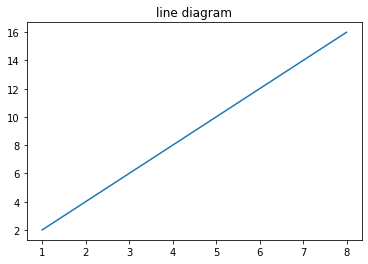

In [13]:
# line diagram
import matplotlib.pyplot as plt
plt.title("line diagram")
x=[1,2,3,4,5,6,7,8]
y=[2,4,6,8,10,12,14,16]
plt.plot(x,y)
plt.show()

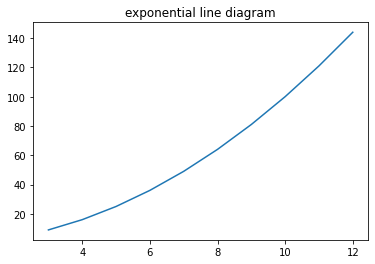

In [14]:
# another example
import matplotlib.pyplot as plt
plt.title("exponential line diagram")
x=[3,4,5,6,7,8,9,10,11,12]
y= [9,16,25,36,49,64,81,100,121,144]
plt.plot(x,y)
plt.show()

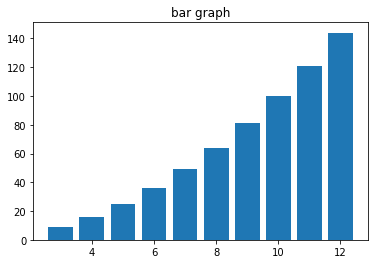

In [15]:
# bar graph
import matplotlib.pyplot as plt
plt.title("bar graph")
x=[3,4,5,6,7,8,9,10,11,12]
y= [9,16,25,36,49,64,81,100,121,144]
plt.bar(x,y)
plt.show()

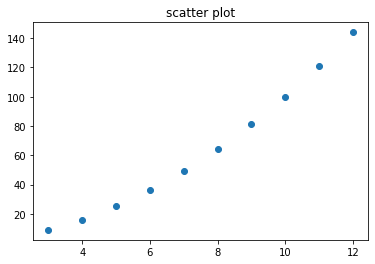

In [16]:
# scatter plot
import matplotlib.pyplot as plt
plt.title("scatter plot")
x=[3,4,5,6,7,8,9,10,11,12]
y= [9,16,25,36,49,64,81,100,121,144]
plt.scatter(x,y)
plt.show()

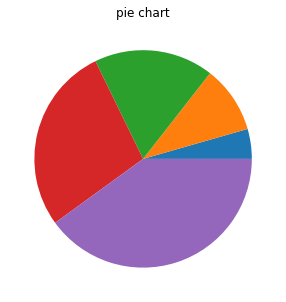

In [19]:
# pie chart
import matplotlib.pyplot as plt
x=[4,9,16,25,36]
fig = plt.figure(figsize =(9, 5)) # line 4
plt.title("pie chart")
plt.pie(x)
plt.show()

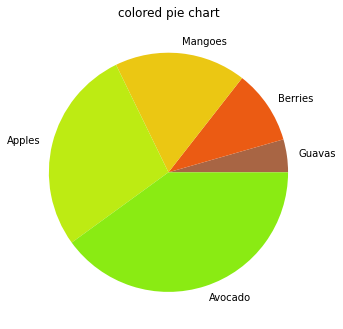

In [21]:
# colored pie chart
import matplotlib.pyplot as plt
x=[4,9,16,25,36]
fig = plt.figure(figsize =(5.5, 5.5))
plt.pie(x, labels=("Guavas", "Berries","Mangoes","Apples", "Avocado"),
colors = ( "#a86544", "#eb5b13", "#ebc713", "#bdeb13", "#8aeb13"))
plt.title("colored pie chart")
plt.show()

As we now know more about the graphical capabilities of Jupyter lets go to the taxi task.

First excercise: Show me New York with leafmap as a hybrid google map at a zoom of 12 and with a height of 450px and a width of 800px and finally a maximum zoom of 20.

In [4]:
print('Starting first leafmap test...')

import leafmap
#center to New York at 41 degrees north and 74 degrees west
m = leafmap.Map(google_map="HYBRID",center=[40.702557, -74.012318], zoom=12,height="450px", width="800px",max_zoom="20")  #center=[lat, lon]
#show
m

Starting first leafmap test...


Map(center=[40.702557, -74.012318], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

Second Excercise: Parse available yellow and green taxi dataset to a variable by streaming and preserve all information from the csv. Use a class, type hints and multithreading. Make sure the data is available and show the min-max-timeframe where your data is available. Prepare adjustment for time ranges that skip already loaded tables. For testing print minimum and maximum available pickup time.

Show available file types for taxis and the minimum and maximum pickup times found:

In [5]:
import read_taxidata

print('Starting first leafmap test...')
td = read_taxidata.TaxiData('/home/benjamin-elias/Proseminar/Jupyterlab/taxi_data/')
here_files = td.get_date_files(2021, 3)
print(here_files)
td.load_add_available(here_files)
print('Minimum and Maximum time available:')
print(td.get_minmax_available_pickup_time())

Starting first leafmap test...
{'yellow': [datetime.datetime(2021, 3, 1, 0, 0)], 'green': [datetime.datetime(2021, 3, 1, 0, 0)]}
Minimum and Maximum time available:
(datetime.datetime(2019, 1, 1, 0, 0), datetime.datetime(2021, 7, 31, 23, 59, 58))


Third Excercise: Parse the taxi zone lookup. Keep it forever.

In [6]:
import read_taxizone

tz = read_taxizone.TaxiZone('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/taxi_data/taxi+_zone_lookup.csv')
print('Printing zone 29:')
print(tz.get_from_location_id(29))
print('Printing neighbourhood Windsor Terrace:')
print(tz.get_from_neighborhood_name('Windsor Terrace'))

Printing zone 29:
(29, 'Brooklyn', 'Brighton Beach', 'Boro Zone')
Printing neighbourhood Windsor Terrace:
(257, 'Brooklyn', 'Windsor Terrace', 'Boro Zone')


Fourth Excercise: Add the Neighbourhoods layer to the map.

In [7]:
import leafmap
#center to New York at 41 degrees north and 74 degrees west
m = leafmap.Map(google_map="HYBRID",center=[40.702557, -74.012318], zoom=12,height="600px", width="1200px",max_zoom="20")  #center=[lat, lon]
#show
print('Showing current layer names before adding neighbourhoods:')
print(m.get_layer_names())
print('Add geojson layer neighbourhoods:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/nyc-neighborhoods.geojson', layer_name='neighbourhoods', style={}, hover_style={}, style_callback=None, fill_colors=['red'], info_mode='on_hover')
m.layer_opacity('neighbourhoods', 0.3)
print(m.get_layer_names())
m

Showing current layer names before adding neighbourhoods:
['OpenStreetMap', 'Google Satellite']
Add geojson layer neighbourhoods:
['OpenStreetMap', 'Google Satellite', 'neighbourhoods']


Map(center=[40.702557, -74.012318], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

Fifth Excercise: Fill all neighbourhoods with random colors and add again.

In [8]:
import leafmap
import random
from typing import List
#center to New York at 41 degrees north and 74 degrees west
m = leafmap.Map(google_map="HYBRID",center=[40.702557, -74.012318], zoom=12,height="600px", width="1200px",max_zoom="20")  #center=[lat, lon]
#show
print('Showing current layer names before adding neighbourhoods:')
print(m.get_layer_names())
print('Random color hex:')
r = lambda: random.randint(0,255)
print('#%02X%02X%02X' % (r(),r(),r()))
print('Random color hex list:')
color_list: List[str] = []
for i in range(0, len(tz.zones)):
    color_list.append('#%02X%02X%02X' % (r(), r(), r()))
print('Add geojson layer neighbourhoods, color is sorted by geojson polygon order:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/nyc-neighborhoods.geojson', layer_name='neighbourhoods', style={}, hover_style={}, style_callback=None, fill_colors=color_list, info_mode='on_hover')
m.layer_opacity('neighbourhoods', 0.3)
print(m.get_layer_names())
m

Showing current layer names before adding neighbourhoods:
['OpenStreetMap', 'Google Satellite']
Random color hex:
#6BDEC1
Random color hex list:
Add geojson layer neighbourhoods, color is sorted by geojson polygon order:
['OpenStreetMap', 'Google Satellite', 'neighbourhoods']


Map(center=[40.702557, -74.012318], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

Sixth Excercise: Manually parse the Neighbourhoods layer and calculate the central pinpoint of each, show the pinpoints on the map and oriented on that the neighbourhood name. Make sure you are able to connect the taxi zone information with the geojson for nyc neighborhoods. Maybe correct the taxi zones and use Levenshtein distance to estimate the correct target names first.

First we show how to find the correct taxi zone for each neighborhood. Remind yourself that there are less neighborhoods than taxizones, so that the taxi zones are pretty detailed and cover only one neighborhood. In the end of the first scan not all taxi zones will be used. To have a good filtering system we should scan the geojson with the taxi zones now to make a double join of data.

In [9]:
from read_neighbourhoods import NeighbourhoodTaxiData
nd = NeighbourhoodTaxiData('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/nyc-neighborhoods.geojson')

Multiple found: Williamsburg
{(256, 'Brooklyn', 'Williamsburg (South Side)', 'Boro Zone'), (255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone'), (217, 'Brooklyn', 'South Williamsburg', 'Boro Zone'), (80, 'Brooklyn', 'East Williamsburg', 'Boro Zone')}
Length analysis showed that this should be correct on the input taxi lookup table:
(255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone')

Multiple found: South Williamsburg
{(255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone'), (217, 'Brooklyn', 'South Williamsburg', 'Boro Zone')}
Length analysis showed that this should be correct on the input taxi lookup table:
(217, 'Brooklyn', 'South Williamsburg', 'Boro Zone')

Multiple found: East Williamsburg
{(255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone'), (80, 'Brooklyn', 'East Williamsburg', 'Boro Zone')}
Length analysis showed that this should be correct on the input taxi lookup table:
(80, 'Brooklyn', 'East Williamsburg', 'Boro Zon

Since the last step we have two lists within NeighborhoodData. Those are the following list of tuples where the index references to another list of polygon lists (that cannot be printed because of size):

In [10]:
for n in nd.neighbourhoodTuples:
    print(n)

(112, 'Brooklyn', 'Greenpoint', 'Boro Zone')
(255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone')
(217, 'Brooklyn', 'South Williamsburg', 'Boro Zone')
(80, 'Brooklyn', 'East Williamsburg', 'Boro Zone')
(33, 'Brooklyn', 'Brooklyn Heights', 'Boro Zone')
(65, 'Brooklyn', 'Downtown Brooklyn/MetroTech', 'Boro Zone')
(97, 'Brooklyn', 'Fort Greene', 'Boro Zone')
(49, 'Brooklyn', 'Clinton Hill', 'Boro Zone')
(34, 'Brooklyn', 'Brooklyn Navy Yard', 'Boro Zone')
(17, 'Brooklyn', 'Bedford', 'Boro Zone')
(36, 'Brooklyn', 'Bushwick North (West)', 'Boro Zone')
(37, 'Brooklyn', 'Bushwick South (East)/The Evergreens Cemetery', 'Boro Zone')
(63, 'Brooklyn', 'Cypress Hills', 'Boro Zone')
(77, 'Brooklyn', 'East New York (North)/Pennsylvania Avenue', 'Boro Zone')
(76, 'Brooklyn', 'East New York/New Lots/City Line', 'Boro Zone')
(222, 'Brooklyn', 'Starrett City/Shirley Chisholm State Park', 'Boro Zone')
(40, 'Brooklyn', 'Carroll Gardens', 'Boro Zone')
(181, 'Brooklyn', 'Park Slope', 'Boro Zon

In the last step we calculate the middle pin points of the polygons whom the taxi zone tuples are pointing to right now and add the three lists (taxi zone tuple list, polygon list and centrals list) to a geojson output.

In [11]:
print('Central point list:')
for c in nd.central_points():
    print(c)
nd.to_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/taxi_zones.geojson')

Central point list:
(-73.94774222479111, 40.72943730469232)
(-73.95799521274463, 40.7146299981626)
(-73.95542526634905, 40.70303150527341)
(-73.93512570600026, 40.713531844483825)
(-73.9949420738628, 40.694908632295586)
(-73.98610052266547, 40.69469776397623)
(-73.97363879405397, 40.69232668515191)
(-73.96452416929192, 40.68898259421262)
(-73.97899640763016, 40.70594713511322)
(-73.94195070585454, 40.68708271672516)
(-73.92615074293467, 40.70078203400203)
(-73.9072806743975, 40.68787973931529)
(-73.88308595783863, 40.688155655022165)
(-73.88855595160125, 40.67269354456475)
(-73.87768598391077, 40.66416512526354)
(-73.88073201609768, 40.643446740247)
(-74.00583529237828, 40.676194328995926)
(-73.97957587697884, 40.67220807084388)
(-73.98214716476525, 40.657746462676435)
(-74.01051464599202, 40.64835143930654)
(-73.99116925479412, 40.652138273497314)
(-73.96753716038879, 40.67747142549298)
(-73.94272336814319, 40.67394740325123)
(-73.93609667783608, 40.66679218182402)
(-73.94593711355529

Seventh Excercise: Load and add the generated geojson layer to the map, which contains the taxi zones. Link it to the taxi usage over the most recent month parsed in exercise 3 and show it on the map by using lines between the neighbourhood center pinpoints. Add an extra variable to save yellow and green to the read_taxidata.py

First print generated taxi zone geojson. Note how a few neighborhoods now fall together with the same color, resebling a united taxi zone.

In [12]:
import leafmap
import random
from typing import List
#center to New York at 41 degrees north and 74 degrees west
m = leafmap.Map(google_map="HYBRID",center=[40.702557, -74.012318], zoom=12,height="600px", width="1200px",max_zoom="20")  #center=[lat, lon]
#show
print('Showing current layer names before adding neighbourhoods:')
print(m.get_layer_names())
print('Random color hex list:')
r = lambda: random.randint(0,255)
color_list: List[str] = []
for i in range(0, len(tz.zones)):
    color_list.append('#%02X%02X%02X' % (r(), r(), r()))
print('Add geojson layer neighbourhoods, color is sorted by geojson polygon order:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/nyc-neighborhoods.geojson', layer_name='neighbourhoods', style={}, hover_style={}, style_callback=None, fill_colors=color_list, info_mode='on_hover')
m.layer_opacity('neighbourhoods', 0.3)
color_list: List[str] = []
for i in range(0, len(nd.feature_collection.features)):
    color_list.append('#%02X%02X%02X' % (r(), r(), r()))
print('Add geojson layer taxi_zones, color is sorted by geojson polygon order:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/taxi_zones.geojson', layer_name='taxi_zones', style={}, hover_style={}, style_callback=None, fill_colors=color_list, info_mode='on_hover')
m.layer_opacity('taxi_zones', 0.8)
print(m.get_layer_names())
m

Showing current layer names before adding neighbourhoods:
['OpenStreetMap', 'Google Satellite']
Random color hex list:
Add geojson layer neighbourhoods, color is sorted by geojson polygon order:
Add geojson layer taxi_zones, color is sorted by geojson polygon order:
['OpenStreetMap', 'Google Satellite', 'neighbourhoods', 'taxi_zones']


Map(center=[40.702557, -74.012318], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

Eighth Excercise: Add a time widget to the map so you can select date and time. The widget is limited to the minimal and the maximum time found within the folder "taxi_data".

In [13]:
from get_drives_by_time import TaxiTime
from datetime import datetime
import leafmap

tt = TaxiTime('/home/benjamin-elias/Proseminar/Jupyterlab/taxi_data/', '/home/benjamin-elias/PycharmProjects'
                                                                           '/Proseminar '
                                                                           'Jupyter-Leafmap/nyc-neighborhoods.geojson')
# standard range load
start = datetime(2020, 2, 10)
end = datetime(2020, 5, 25)
tt.load_range(start, end)
print('Analyze time between 10-02-2020 and 25-05-2020')
print(tt.min_is_loaded)
print(tt.max_is_loaded)

# taxi drive connections and neighborhood central points on map
con = tt.interconnections(start, end, '/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/rides.geojson')
points = tt.zone_neighborhoods.neighbourhood_points('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/neighborhood_centers.geojson')

Multiple found: Williamsburg
{(256, 'Brooklyn', 'Williamsburg (South Side)', 'Boro Zone'), (255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone'), (217, 'Brooklyn', 'South Williamsburg', 'Boro Zone'), (80, 'Brooklyn', 'East Williamsburg', 'Boro Zone')}
Length analysis showed that this should be correct on the input taxi lookup table:
(255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone')

Multiple found: South Williamsburg
{(255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone'), (217, 'Brooklyn', 'South Williamsburg', 'Boro Zone')}
Length analysis showed that this should be correct on the input taxi lookup table:
(217, 'Brooklyn', 'South Williamsburg', 'Boro Zone')

Multiple found: East Williamsburg
{(255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone'), (80, 'Brooklyn', 'East Williamsburg', 'Boro Zone')}
Length analysis showed that this should be correct on the input taxi lookup table:
(80, 'Brooklyn', 'East Williamsburg', 'Boro Zon

Ninth Excercise: Efficiently parse the time from taxi_data from the datasets available. On change the time frame is checked, when shrinked time sets are popped and removed, when increased, time sets are pushed to front or to the back and drawn to the map. Also upgrade the interconnections between the neighbourhoods within this timeframe.

In [ ]:
# efficient range reload
start = datetime(2020, 3, 10)
end = datetime(2020, 6, 25)
tt.load_range(start, end)
print('Analyze time between 10-03-2020 and 25-06-2020')
print(tt.min_is_loaded)
print(tt.max_is_loaded)

# taxi drive connections and neighborhood central points on map
con = tt.interconnections(start, end, '/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/rides.geojson')
points = tt.zone_neighborhoods.neighbourhood_points('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/neighborhood_centers.geojson')

In [2]:
from get_drives_by_time import TaxiTime
from datetime import datetime

tt = TaxiTime('/home/benjamin-elias/Proseminar/Jupyterlab/taxi_data/', '/home/benjamin-elias/PycharmProjects'
                                                                           '/Proseminar '
                                                                           'Jupyter-Leafmap/nyc-neighborhoods.geojson')
# speed range resize to smaller subset of current load
start = datetime(2020, 4, 10)
end = datetime(2020, 4, 11)
tt.load_range(start, end)
print('Analyze time between 10-04-2020 and 11-04-2020')
print(tt.min_is_loaded)
print(tt.max_is_loaded)

# taxi drive connections and neighborhood central points on map
con = tt.interconnections(start, end, '/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/rides.geojson')
points = tt.zone_neighborhoods.neighbourhood_points('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/neighborhood_centers.geojson')

# cannot print connections because they go into the millions
# for c in con:
    # print(c)

print()
for p in points:
    print(p)

Multiple found: Williamsburg
{(80, 'Brooklyn', 'East Williamsburg', 'Boro Zone'), (255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone'), (217, 'Brooklyn', 'South Williamsburg', 'Boro Zone'), (256, 'Brooklyn', 'Williamsburg (South Side)', 'Boro Zone')}
Length analysis showed that this should be correct on the input taxi lookup table:
(255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone')

Multiple found: South Williamsburg
{(255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone'), (217, 'Brooklyn', 'South Williamsburg', 'Boro Zone')}
Length analysis showed that this should be correct on the input taxi lookup table:
(217, 'Brooklyn', 'South Williamsburg', 'Boro Zone')

Multiple found: East Williamsburg
{(80, 'Brooklyn', 'East Williamsburg', 'Boro Zone'), (255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone')}
Length analysis showed that this should be correct on the input taxi lookup table:
(80, 'Brooklyn', 'East Williamsburg', 'Boro Zon

Show the connections and points for neighborhoods on the map:

In [7]:
import leafmap
import random
from typing import List
import read_taxizone

tz = read_taxizone.TaxiZone('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/taxi_data/taxi+_zone_lookup.csv')
#center to New York at 41 degrees north and 74 degrees west
m = leafmap.Map(google_map="HYBRID",center=[40.702557, -74.012318], zoom=12,height="600px", width="1200px",max_zoom="20")  #center=[lat, lon]
#show
print('Showing current layer names before adding neighbourhoods:')
print(m.get_layer_names())
print('Random color hex list:')
r = lambda: random.randint(0,255)
color_list: List[str] = []
for i in range(0, len(tz.zones)):
    color_list.append('#%02X%02X%02X' % (r(), r(), r()))
print('Add geojson layer neighbourhoods, color is sorted by geojson polygon order:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/nyc-neighborhoods.geojson', layer_name='neighbourhoods', style={}, hover_style={}, style_callback=None, fill_colors=color_list, info_mode='on_hover')
m.layer_opacity('neighbourhoods', 0.3)
color_list: List[str] = []
for i in range(0, len(tt.zone_neighborhoods.feature_collection.features)):
    color_list.append('#%02X%02X%02X' % (r(), r(), r()))
print('Add geojson layer taxi_zones, color is sorted by geojson polygon order:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/taxi_zones.geojson', layer_name='taxi_zones', style={}, hover_style={}, style_callback=None, fill_colors=color_list, info_mode='on_hover')
m.layer_opacity('taxi_zones', 0.3)
print(m.get_layer_names())
print('Add geojson layer rides:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/rides.geojson', layer_name='rides', style={}, hover_style={}, style_callback=None, fill_colors=color_list, info_mode='on_hover')
m.layer_opacity('rides', 0.9)
print(m.get_layer_names())
print('Add geojson layer neighborhood_centers:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/neighborhood_centers.geojson', layer_name='neighborhood_centers', style={}, hover_style={}, style_callback=None, fill_colors=color_list, info_mode='on_hover')
m.layer_opacity('neighborhood_centers', 0.9)
print(m.get_layer_names())
m

Showing current layer names before adding neighbourhoods:
['OpenStreetMap', 'Google Satellite']
Random color hex list:
Add geojson layer neighbourhoods, color is sorted by geojson polygon order:
Add geojson layer taxi_zones, color is sorted by geojson polygon order:
['OpenStreetMap', 'Google Satellite', 'neighbourhoods', 'taxi_zones']
Add geojson layer rides:
['OpenStreetMap', 'Google Satellite', 'neighbourhoods', 'taxi_zones', 'rides']
Add geojson layer neighborhood_centers:
['OpenStreetMap', 'Google Satellite', 'neighbourhoods', 'taxi_zones', 'rides', 'neighborhood_centers']


Map(center=[40.702557, -74.012318], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

Tenth Excercise: Add a heatmap containing the colors blue for start destination and red for target destination and draw them as a mixed color into the neighbourhoods into a new layer below the lines layer showing the interconnections. The intensity of the colors should be in comparison to the overall count of starts and arrivals for each neighbourhood.

In [29]:
import leafmap
import random
from typing import List
import read_taxizone

tz = read_taxizone.TaxiZone('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/taxi_data/taxi+_zone_lookup.csv')
#center to New York at 41 degrees north and 74 degrees west
m = leafmap.Map(google_map="HYBRID",center=[40.702557, -74.012318], zoom=12,height="600px", width="1200px",max_zoom="20")  #center=[lat, lon]
#show
print('Showing current layer names before adding neighbourhoods:')
print(m.get_layer_names())
print('Random color hex list:')
r = lambda: random.randint(0,255)
color_list: List[str] = []
for i in range(0, len(tz.zones)):
    color_list.append('#%02X%02X%02X' % (r(), r(), r()))
"""
print('Add geojson layer neighbourhoods, color is sorted by geojson polygon order:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/nyc-neighborhoods.geojson', layer_name='neighbourhoods', style={}, hover_style={}, style_callback=None, fill_colors=color_list, info_mode='on_hover')
m.layer_opacity('neighbourhoods', 0.5)
color_list: List[str] = []
for i in range(0, len(tt.zone_neighborhoods.feature_collection.features)):
    color_list.append('#%02X%02X%02X' % (r(), r(), r()))
"""
print('Add geojson layer taxi_zones, color is sorted by geojson polygon order:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/taxi_zones.geojson', layer_name='taxi_zones', style={}, hover_style={}, style_callback=None, fill_colors=color_list, info_mode='on_hover')
m.layer_opacity('taxi_zones', 0.3)
print(m.get_layer_names())

print('Add csv layer heatmap for pickups:')
from con_geojson_to_heatmap import Heatmapper

h = Heatmapper('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/rides.geojson',
               '/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/heat_of_april.csv')
# there is a bug in heatmap swapping longitude and latitude, changing the csv will else continue the bug
m.add_heatmap('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/heat_of_april.csv', latitude='longitude', longitude='latitude', value='heat_property_val', name='Heat map', radius=40)
m.layer_opacity('Heat map', 0.9)
print(m.get_layer_names())
"""
print('Add geojson layer rides:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/rides.geojson', layer_name='rides', style={}, hover_style={}, style_callback=None, fill_colors=color_list, info_mode='on_hover')
m.layer_opacity('rides', 0.1)
print(m.get_layer_names())
"""
"""
print('Add geojson layer neighborhood_centers:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/neighborhood_centers.geojson', layer_name='neighborhood_centers', style={}, hover_style={}, style_callback=None, fill_colors=color_list, info_mode='on_hover')
m.layer_opacity('neighborhood_centers', 0.1)
print(m.get_layer_names())
"""
m

Showing current layer names before adding neighbourhoods:
['OpenStreetMap', 'Google Satellite']
Random color hex list:
Add geojson layer taxi_zones, color is sorted by geojson polygon order:
['OpenStreetMap', 'Google Satellite', 'taxi_zones']
Add csv layer heatmap for pickups:
['OpenStreetMap', 'Google Satellite', 'taxi_zones', 'Heat map']


Map(center=[40.702557, -74.012318], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

Eleventh Exercise:

1. Add a time filter (or optionally widget) so we can only see time sets from certain daytimes within the overall time range.
2. Add a passenger filter that can limit the passenger count within ranges. Refer minimum and maximum from values found. Repeat that with the taxi color and the vendor ID.
3. Add a filter that can limit the distance moved count within ranges. Refer minimum and maximum from values found.
4. Add a filter that can limit the money spent on the trip within ranges. Refer minimum and maximum from values found.
5. Add a filter that can limit the neighbourhoods either on start (S) or arrival (A) using one string for mode and one string separated with commas to list the neighbourhoods. If anything is empty the filter is off.
6. Add a filter that can select the payment type on the trip. Refer values available.

Final approach:

In [1]:
from get_drives_by_time import TaxiTime
from datetime import datetime, time
import leafmap
import random
from typing import List
import read_taxizone
import get_drives_by_time

tt = TaxiTime('/home/benjamin-elias/Proseminar/Jupyterlab/taxi_data/', '/home/benjamin-elias/PycharmProjects'
                                                                       '/Proseminar '
                                                                       'Jupyter-Leafmap/nyc-neighborhoods.geojson')
# standard range load with hours and minutes
start = datetime(2020, 3, 10, 1, 1)
end = datetime(2020, 3, 12, 1, 2)
tt.load_range(start, end)
print('Analyze time between 10-02-2020 01:01 and 25-05-2020 01:02')
print(tt.min_is_loaded)
print(tt.max_is_loaded)

print('Filters:')
# limit to main work time
tt.daytime_filter(time(8), time(17))
# limit trip distance
tt.value_filter(0, 20)
# limit Pickup to Bloomingdale
tt.flag_filter('Bloomingdale/Upper West Side North', method=get_drives_by_time.PICKUP_LOCATION,
               zone_checker=read_taxizone.ZONE)

# taxi drive connections and neighborhood central points on map
con = tt.interconnections('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/rides.geojson')
points = tt.zone_neighborhoods.neighbourhood_points('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/neighborhood_centers.geojson')

# center to New York at 41 degrees north and 74 degrees west
m = leafmap.Map(google_map="HYBRID", center=[40.702557, -74.012318], zoom=12, height="600px", width="1200px",
                max_zoom="20")  # center=[lat, lon]
# show
print('Showing current layer names before adding neighbourhoods:')
print(m.get_layer_names())
print('Random color hex list:')
r = lambda: random.randint(0, 255)
color_list: List[str] = []
for i in range(0, len(tt.zone_neighborhoods.taxi_zone.zones)):
    color_list.append('#%02X%02X%02X' % (r(), r(), r()))

print('Add geojson layer neighbourhoods, color is sorted by geojson polygon order:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/nyc-neighborhoods.geojson',
              layer_name='neighbourhoods', style={}, hover_style={}, style_callback=None, fill_colors=color_list,
              info_mode='on_hover')
m.layer_opacity('neighbourhoods', 0.5)
color_list: List[str] = []
for i in range(0, len(tt.zone_neighborhoods.feature_collection.features)):
    color_list.append('#%02X%02X%02X' % (r(), r(), r()))

print('Add geojson layer taxi_zones, color is sorted by geojson polygon order:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/taxi_zones.geojson',
              layer_name='taxi_zones', style={}, hover_style={}, style_callback=None, fill_colors=color_list,
              info_mode='on_hover')
m.layer_opacity('taxi_zones', 0.3)
print(m.get_layer_names())

print('Add csv layer heatmap for pickups:')
from con_geojson_to_heatmap import Heatmapper

h = Heatmapper('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/rides.geojson',
               '/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/heat_of_april.csv')
# there is a bug in heatmap swapping longitude and latitude, changing the csv will else continue the bug
m.add_heatmap('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/heat_of_april.csv',
              latitude='longitude', longitude='latitude', value='heat_property_val', name='Heat map', radius=40)
m.layer_opacity('Heat map', 0.9)
print(m.get_layer_names())

print('Add geojson layer rides:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/rides.geojson', layer_name='rides',
              style={}, hover_style={}, style_callback=None, fill_colors=color_list, info_mode='on_hover')
m.layer_opacity('rides', 0.1)
print(m.get_layer_names())

print('Add geojson layer neighborhood_centers:')
m.add_geojson('/home/benjamin-elias/PycharmProjects/Proseminar Jupyter-Leafmap/neighborhood_centers.geojson',
              layer_name='neighborhood_centers', style={}, hover_style={}, style_callback=None,
              fill_colors=color_list, info_mode='on_hover')
m.layer_opacity('neighborhood_centers', 0.1)
print(m.get_layer_names())
m

/home/benjamin-elias/.local/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Multiple found: Williamsburg
{(255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone'), (256, 'Brooklyn', 'Williamsburg (South Side)', 'Boro Zone'), (217, 'Brooklyn', 'South Williamsburg', 'Boro Zone'), (80, 'Brooklyn', 'East Williamsburg', 'Boro Zone')}
Length analysis showed that this should be correct on the input taxi lookup table:
(255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone')

Multiple found: South Williamsburg
{(217, 'Brooklyn', 'South Williamsburg', 'Boro Zone'), (255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone')}
Length analysis showed that this should be correct on the input taxi lookup table:
(217, 'Brooklyn', 'South Williamsburg', 'Boro Zone')

Multiple found: East Williamsburg
{(255, 'Brooklyn', 'Williamsburg/Williamsburg (North)', 'Boro Zone'), (80, 'Brooklyn', 'East Williamsburg', 'Boro Zone')}
Length analysis showed that this should be correct on the input taxi lookup table:
(80, 'Brooklyn', 'East Williamsburg', 'Boro Zon

Map(center=[40.702557, -74.012318], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…